<a href="https://colab.research.google.com/github/changsin/ClassifyImages/blob/main/notebooks/dashboard_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
Install requirements and prepare the dataset for training.



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
DATA_ROOT = "/content/drive/MyDrive/data/Top15/train_top15_a_seatbelt/"

In [3]:
import glob
import os

def glob_files(path, file_type="*"):
    search_string = os.path.join(path, file_type)
    files = glob.glob(search_string)

    # print('searching ', path)
    paths = []
    for f in files:
      if os.path.isdir(f):
        sub_paths = glob_files(f + '/')
        paths += sub_paths
      else:
        paths.append(f)

    # We sort the images in alphabetical order to match them
    #  to the annotation files
    paths.sort()

    return paths


In [4]:
import cv2
import numpy as np

IMAGE_SIZE = 600

def load_images(path):
  files = glob_files(path, "*.jpg")

  # print(files)
  X_data = []
  for file in files:
    image = cv2.imread(file)
    image = image/255
    # print(image.shape)
    # x = cv2.resize(image, None, fx=0.5, fy=0.5, interpolation=cv2.INTER_AREA)

    X_data.append(image)
  return np.array(X_data)

In [5]:
X = load_images(DATA_ROOT + "train_top15_a_seatbelt_0/")
X.shape

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


(90,)

In [6]:
# WIDTH = 1920
# HEIGHT = 1080

def load_labels(path, X):
  files = glob_files(path, "*.txt")

  Y_data = []
  for file, x in zip(files, X):
    width = x.shape[1]
    height = x.shape[0]
    with open(file) as f:
      lines = f.readlines()

      boxes = []
      for line in lines:
        tokens = line.split()

        class_id = int(tokens[0])
        xc = float(tokens[1]) * width
        yc = float(tokens[2]) * height
        box_width = float(tokens[3]) * width
        box_height = float(tokens[4]) * height

        boxes.append(np.array([class_id, xc, yc, box_width, box_height]))
        # print(class_id, xc, yc, width, height)

      Y_data.append(np.array(boxes))
      # print(lines)
  return np.array(Y_data)

Y = load_labels(DATA_ROOT + "train_top15_a_seatbelt_0/", X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [131]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

COLORS = [(0, 255/255, 0), (255/255, 255/255, 0), (255/255, 0, 0)]

CLASS_NAMES = ["alert@Alternator", "alert@Brake", "alert@Coolant",
        "alert@Distance", "alert@EngineOil", "alert@EngineOilTemp",
        "alert@Parking", "alert@Retaining", "alert@Seatbelt",
        "alert@Steering",

        "warning@ABS", "warning@Brake", "warning@BrakeWear",
        "warning@CentralMonitoring", "warning@EPC", "warning@Engine",
        "warning@Fuel", "warning@Glow", "warning@Headlamp",
        "warning@Lamp", "warning@Parking", "warning@Retaining",
        "warning@StabilityOff", "warning@StabilityOn", "warning@Steering",
        "warning@TPMS", "warning@Tire", "warning@Washer"]

def create_patch_rectangle(y, color=COLORS[2]):
  # # in yolov5
  width = int(y[2])
  height = int(y[3])
  return patches.Rectangle((int(y[0] - width/2), int(y[1] - height/2)),
                           width, height,
                           edgecolor=color, fill=False)

COLORS = [(0, 255/255, 0), (255/255, 255/255, 0), (255/255, 0, 0)]

def plot_image(image, boxes, axis):
  # print(boxes.shape)
  for box in boxes:
    # print(box)
    class_id = int(box[0])
    # print(type(class_id), class_id)
    rect = create_patch_rectangle(box[1:])
    axis.add_patch(rect)

  plt.imshow(image)

def plot_images(X, Y, limit=10):
  fig = plt.figure(figsize=(100, 80))

  last_id = min(limit, X.shape[0])
  for id in range(last_id):
    axis = fig.add_subplot(5, 3, id + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    plot_image(X[id], Y[id], axis)

def plot_label_images(X, Y, limit=10):
  fig = plt.figure(figsize=(10, 8))

  last_id = min(limit, X.shape[0])
  for id in range(last_id):
    axis = fig.add_subplot(5, 3, id + 1)
    axis.get_xaxis().set_visible(False)
    axis.get_yaxis().set_visible(False)
    axis.set_title(CLASS_NAMES[Y[id]])
    axis.imshow(X[id])
  fig.show()

def get_bbox(y):
  width = int(y[2])
  height = int(y[3])
  return int(y[0] - width/2), int(y[1] - height/2), width, height

def plot_labels(X, Y, limit=30):
  fig = plt.figure(figsize=(10, 8))
  last_id = min(limit, X.shape[0])

  print(last_id, limit, X.shape[0])

  label_id = 1
  for id in range(last_id):

    image = X[id]
    for box in Y[id]:
      if label_id >= 100:
        break

      class_id = int(box[0])
      x, y, box_width, box_height = get_bbox(box[1:])
      # print("y:", y, y + box_height, "x:", x, x + box_width)
      # print(image[y:y+box_height, x:x+box_width].shape)

      axis = fig.add_subplot(10, 10, label_id)
      axis.get_xaxis().set_visible(False)
      axis.get_yaxis().set_visible(False)
      axis.imshow(image[y:y+box_height, x:x+box_width])

      axis.show()
      label_id += 1

LABEL_SIZE = 20
def extract_box_image_data(X, Y):
  box_images = []
  box_labels = []
  for id in range(len(X)):
    image = X[id]
    for box in Y[id]:
      class_id = int(box[0])
      box_labels.append(class_id)

      x, y, box_width, box_height = get_box(box[1:])
      box_image = image[y:y+box_height, x:x+box_width]
      # Make sure that you resize all labels.
      # This is necessary for two reasons:
      #   1. If image sizes are different,
      #      the resulting box_images will not be a whole sum np.array.
      #     Instead, it will become an array of arraies
      #   2. For clustering purposes
      box_image = cv2.resize(box_image, (IMAGE_SIZE, IMAGE_SIZE))
      box_images.append(box_image)

  box_images = np.array(box_images)
  box_labels = np.array(box_labels)
  return box_images, box_labels
# plot_images(np.array(X[:1]), np.array(Y[:1]))

In [132]:
# plot_labels(np.array(X[:50]), np.array(Y[:50]), limit=50)

box_images, box_labels = extract_box_image_data(X, Y)

In [133]:
box_labels.shape
box_images.shape

(623, 600, 600, 3)

In [ ]:
plot_label_images(box_images, box_labels)

In [151]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
from scipy.spatial.distance import cdist

from sklearn import preprocessing  # to normalise existing X
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

def to_feature_maps(X):
  #Convert to VGG input format
  # This is not necessary since the input is already normalized when loading
  # X_processed = preprocess_input(X)

  #include_top=False == not getting VGG16 last 3 layers
  model = VGG16(weights="imagenet", include_top=False)

  return model.predict(X)

def get_pca_reduced(X_fm, dimensions=2):
  X_fm_flat = X_fm.reshape(X_fm.shape[0], -1)
  pca = PCA(dimensions)

  X_fm_reduced = pca.fit_transform(X_fm_flat)

  return X_fm_reduced, pca


def get_clusters(X, K):
  kmeans = KMeans(n_clusters=K, random_state=0)
  X_clusters = kmeans.fit(X)

  return X_clusters, kmeans

def to_cluster_idx(cluster_labels, bins):
    """
    param labels: cluster labels
    param bins: range of K
    returns: dictionary of cluster IDs
    """
    cluster_dict = dict()
    for cluster_id in bins:
        cluster_dict[cluster_id] = np.where(cluster_labels == cluster_id)[0]
    return cluster_dict

def cluster_images(X, K=2):
  # make it 2D
  X_reshaped = preprocessing.normalize(X.reshape(len(X), -1))
  X_clusters, kmeans = get_clusters(X_reshaped, K)

  # get the image ids of each cluster
  cluster_idx = to_cluster_idx(X_clusters.labels_, range(K))

  # keep the cluster centers
  print(kmeans.cluster_centers_)
  print(cluster_idx)
  
  # return X_reshaped, kmeans
  return X_reshaped, X_clusters, kmeans

def cluster_images_fm(X, K=2, cosine_distance=True):
  X_fm = to_feature_maps(X)

  # # normalize to use cosine similarity
  if cosine_distance:
    X_fm = preprocessing.normalize(X_fm.reshape(len(X_fm), -1))

  X_clusters_fm, kmeans_fm = get_clusters(X_fm, K)

  # get the image ids of each cluster
  cluster_idx_fm = to_cluster_idx(X_clusters_fm.labels_, range(K))

  # keep the cluster centers
  print(kmeans_fm.cluster_centers_)
  print(cluster_idx_fm)

  return X_fm, X_clusters_fm, kmeans_fm

In [152]:
import matplotlib.pyplot as plt

def plot_data_in_clusters(data, kmeans, idx=None, show_centroids=True):
  marker_size = 7

  # Plot the decision boundary. For that, we will assign a color to each
  x_min, x_max = data[:, 0].min(), data[:, 0].max()
  y_min, y_max = data[:, 1].min(), data[:, 1].max()

  # Step size of the mesh. Decrease to increase the quality of the VQ.
  # point in the mesh [x_min, x_max]x[y_min, y_max].
  h = float((x_max - x_min)/100)

  PADDING = h * marker_size
  x_min, x_max = x_min - PADDING, x_max + PADDING/2
  y_min, y_max = y_min - PADDING, y_max + PADDING

  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  # Obtain labels for each point in mesh. Use last trained model.
  Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

  # Put the result into a color plot
  Z = Z.reshape(xx.shape)

  plt.figure(2)
  # plt.clf()
  plt.imshow(Z, interpolation="nearest",
              extent=(xx.min(), xx.max(), yy.min(), yy.max()),
              cmap=plt.cm.Paired, aspect="auto", origin="lower")

  plt.plot(data[:, 0], data[:, 1], 'k.', markersize=marker_size)

  if show_centroids:
    markers = ["o", "1"]
    # Plot the centroids as a white X
    centroids = kmeans.cluster_centers_

    for id in range(len(centroids)):
      c = centroids[id]
      plt.scatter(c[0], c[1], marker=markers[id], s=150, linewidths=marker_size,
                  color="w", zorder=10)
  if idx:
    for id in idx:
        plt.scatter(data[id, 0], data[id, 1], marker="x",
                    s=150, linewidths=marker_size,
                    color="w", zorder=10)

  plt.title("KMeans clustering")
  plt.xlim(x_min, x_max)
  plt.ylim(y_min, y_max)
  plt.xticks(())
  plt.yticks(())
  plt.show()

In [153]:
idx_a_seatbelt = np.where(CLASS_NAMES.index('alert@Seatbelt') == box_labels)
idx_a_parking = np.where(CLASS_NAMES.index('alert@Parking') == box_labels)

In [ ]:
box_images[idx_a_seatbelt].shape

plot_label_images(box_images[idx_a_seatbelt], box_labels[idx_a_seatbelt])
plot_label_images(box_images[idx_a_parking], box_labels[idx_a_parking])

In [155]:
to_cluster = np.concatenate((box_images[idx_a_seatbelt], box_images[idx_a_parking]))
to_cluster.shape

(135, 600, 600, 3)

In [156]:
X_reshaped, X_clusters, kmeans = cluster_images(to_cluster)

[[3.45760797e-04 2.25822702e-04 8.96995134e-04 ... 3.35542552e-04
  2.04642141e-04 9.52783376e-04]
 [2.67349539e-04 1.23841473e-04 9.01415701e-04 ... 2.78258335e-04
  9.81971136e-05 9.79352094e-04]]
{0: array([ 33,  34,  35,  36,  37,  38,  39,  40,  41,  89,  90,  91,  92,
        93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105,
       106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
       119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131,
       132, 133, 134]), 1: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 42,
       43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59,
       60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76,
       77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88])}


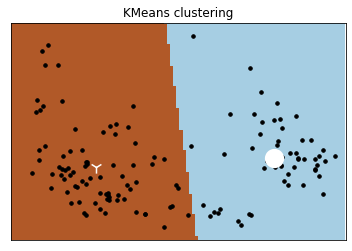

In [149]:
K = 2

# Let's do PCA for visualization
X_reduced, pca = get_pca_reduced(X_reshaped, dimensions=K)
X_clusters_reduced, kmeans_reduced = get_clusters(X_reduced, K)
# plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced, idx=[1])
plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced)

In [157]:
X_reshaped_fm, X_clusters_fm, kmeans_fm = cluster_images_fm(to_cluster)

58900480/58889256 [==============================] - 0s 0us/step
[[8.5525920e-05 0.0000000e+00 6.2615640e-05 ... 0.0000000e+00
  3.5502862e-03 0.0000000e+00]
 [3.2221211e-05 0.0000000e+00 8.4320011e-05 ... 0.0000000e+00
  3.7798276e-03 0.0000000e+00]]
{0: array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89, 101,
       112, 113, 114, 134]), 1: array([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 13

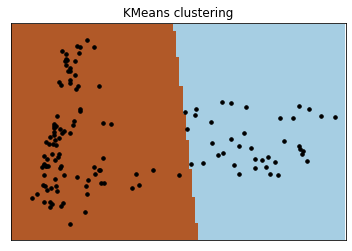

In [158]:
X_reduced_fm, pca_fm = get_pca_reduced(X_reshaped_fm, dimensions=K)
X_clusters_reduced_fm, kmeans_reduced_fm = get_clusters(X_reduced, K)
# plot_data_in_clusters(X_reduced, kmeans=kmeans_reduced, idx=[1])
plot_data_in_clusters(X_reduced_fm, kmeans=kmeans_reduced_fm)

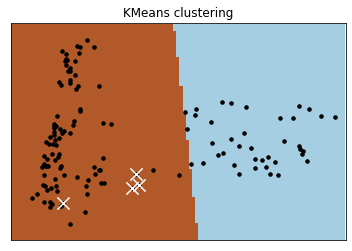

In [159]:
plot_data_in_clusters(X_reduced_fm, kmeans=kmeans_reduced_fm, idx=[112, 113, 114, 134])

In [ ]:
to_cluster_Y = np.concatenate((box_labels[idx_a_seatbelt], box_labels[idx_a_parking]))
plot_label_images(to_cluster[112:114], to_cluster_Y[112:114])


In [ ]:
plot_label_images(to_cluster[85:89], to_cluster_Y[85:89])


In [ ]:
plot_label_images(to_cluster[120:125], to_cluster_Y[120:125])


In [ ]:
plot_label_images(to_cluster[33:40], to_cluster_Y[33:40])
plot_label_images(to_cluster[130:134], to_cluster_Y[130:134])
